In [1]:
import gym
import torch
import random
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [4]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DoubleDQNAgent(state_dim, action_dim)
agent.policy_net.apply(initialize_weights)
agent.target_net.apply(initialize_weights)

episodes = 500
rewards_log = []

for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0
    for _ in range(500):
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
        if done:
            break
    agent.decay_epsilon()
    rewards_log.append(total_reward)

env.close()

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\asas4\anaconda3\envs\ETC\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 500/500 [00:26<00:00, 18.96it/s]


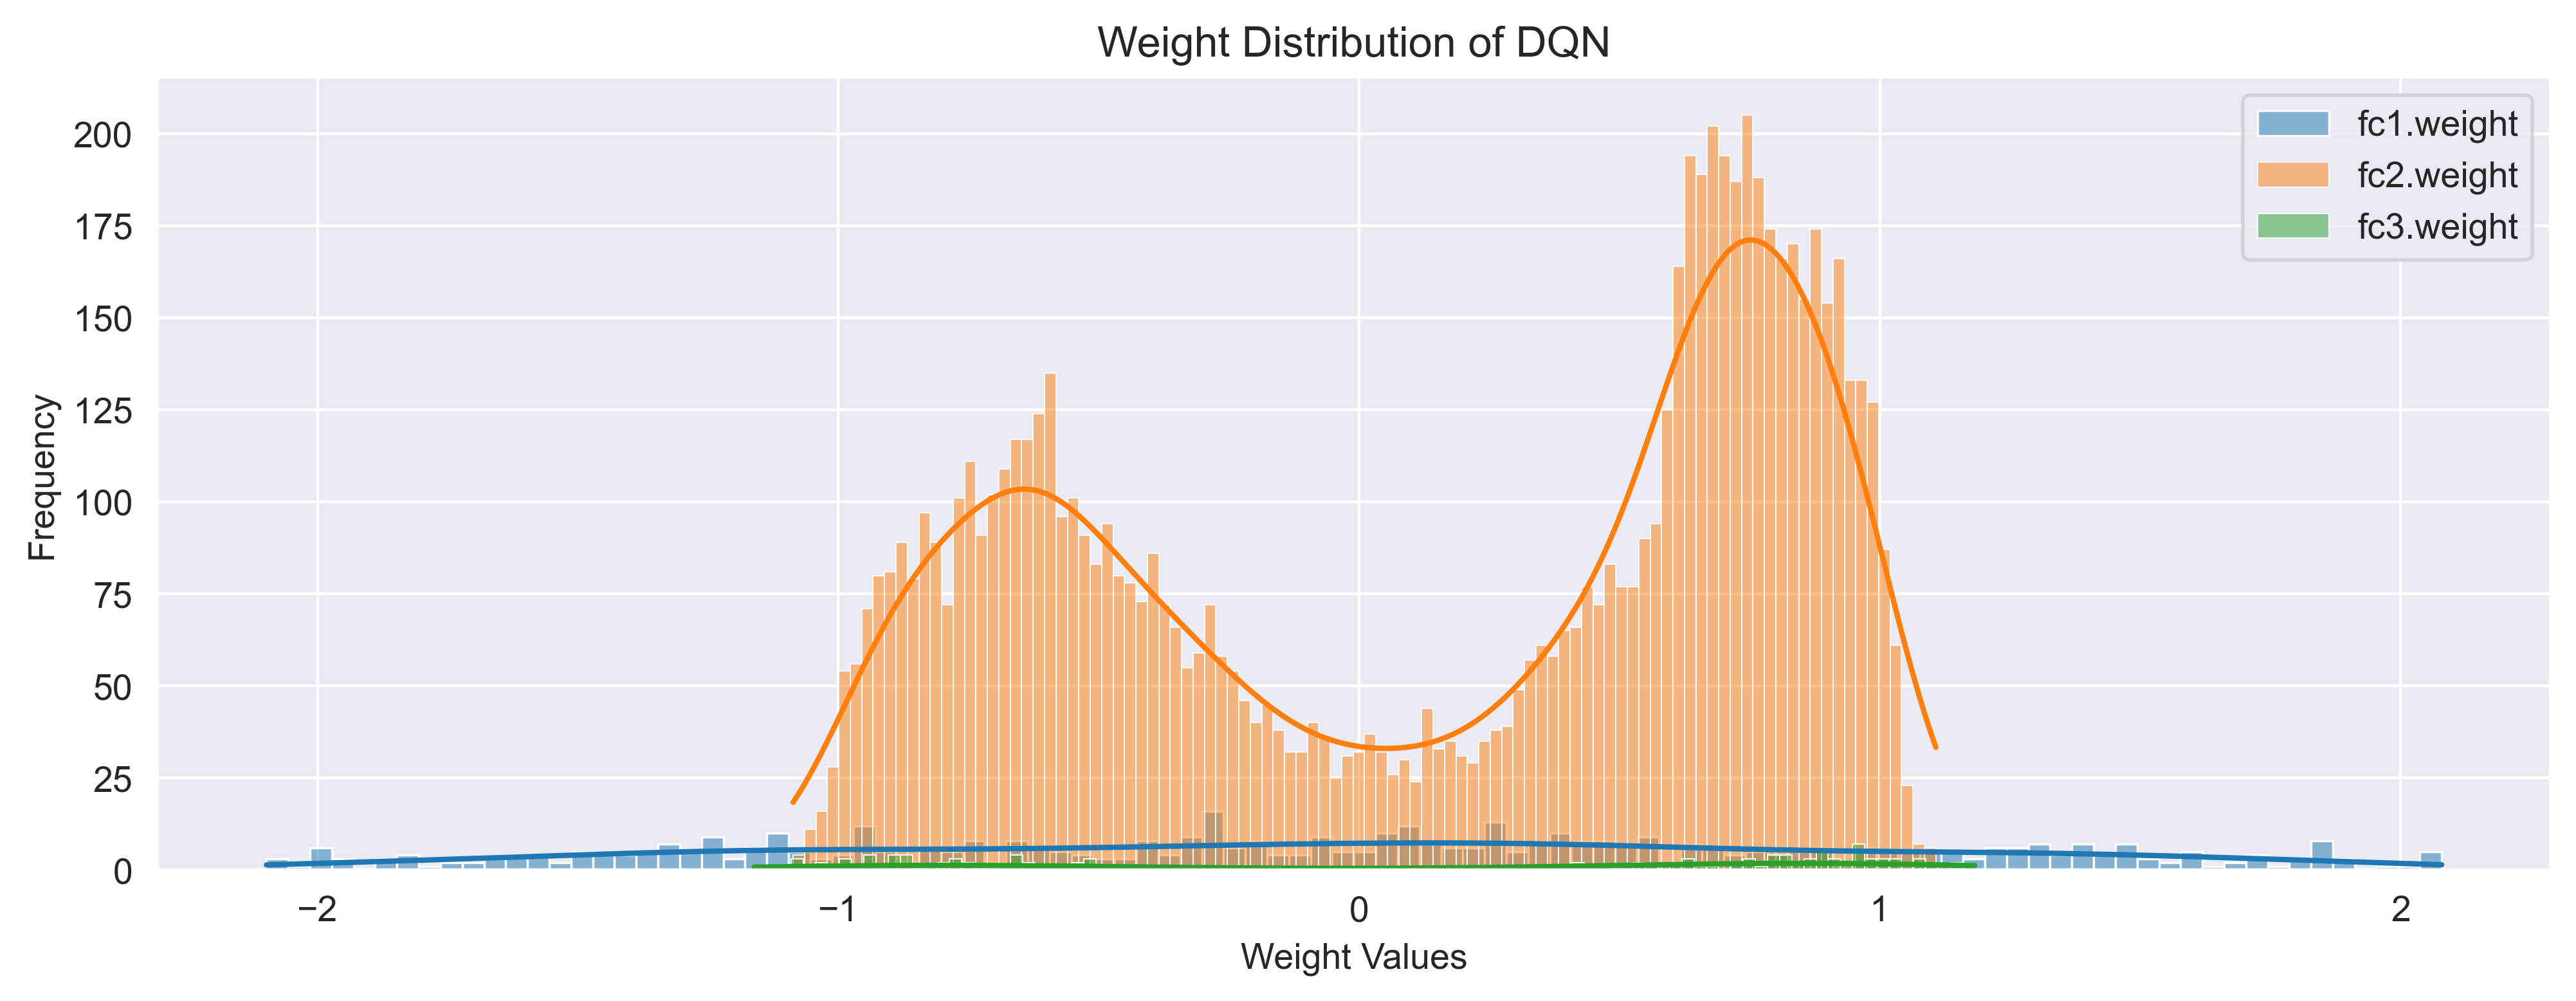

In [5]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(agent.policy_net)

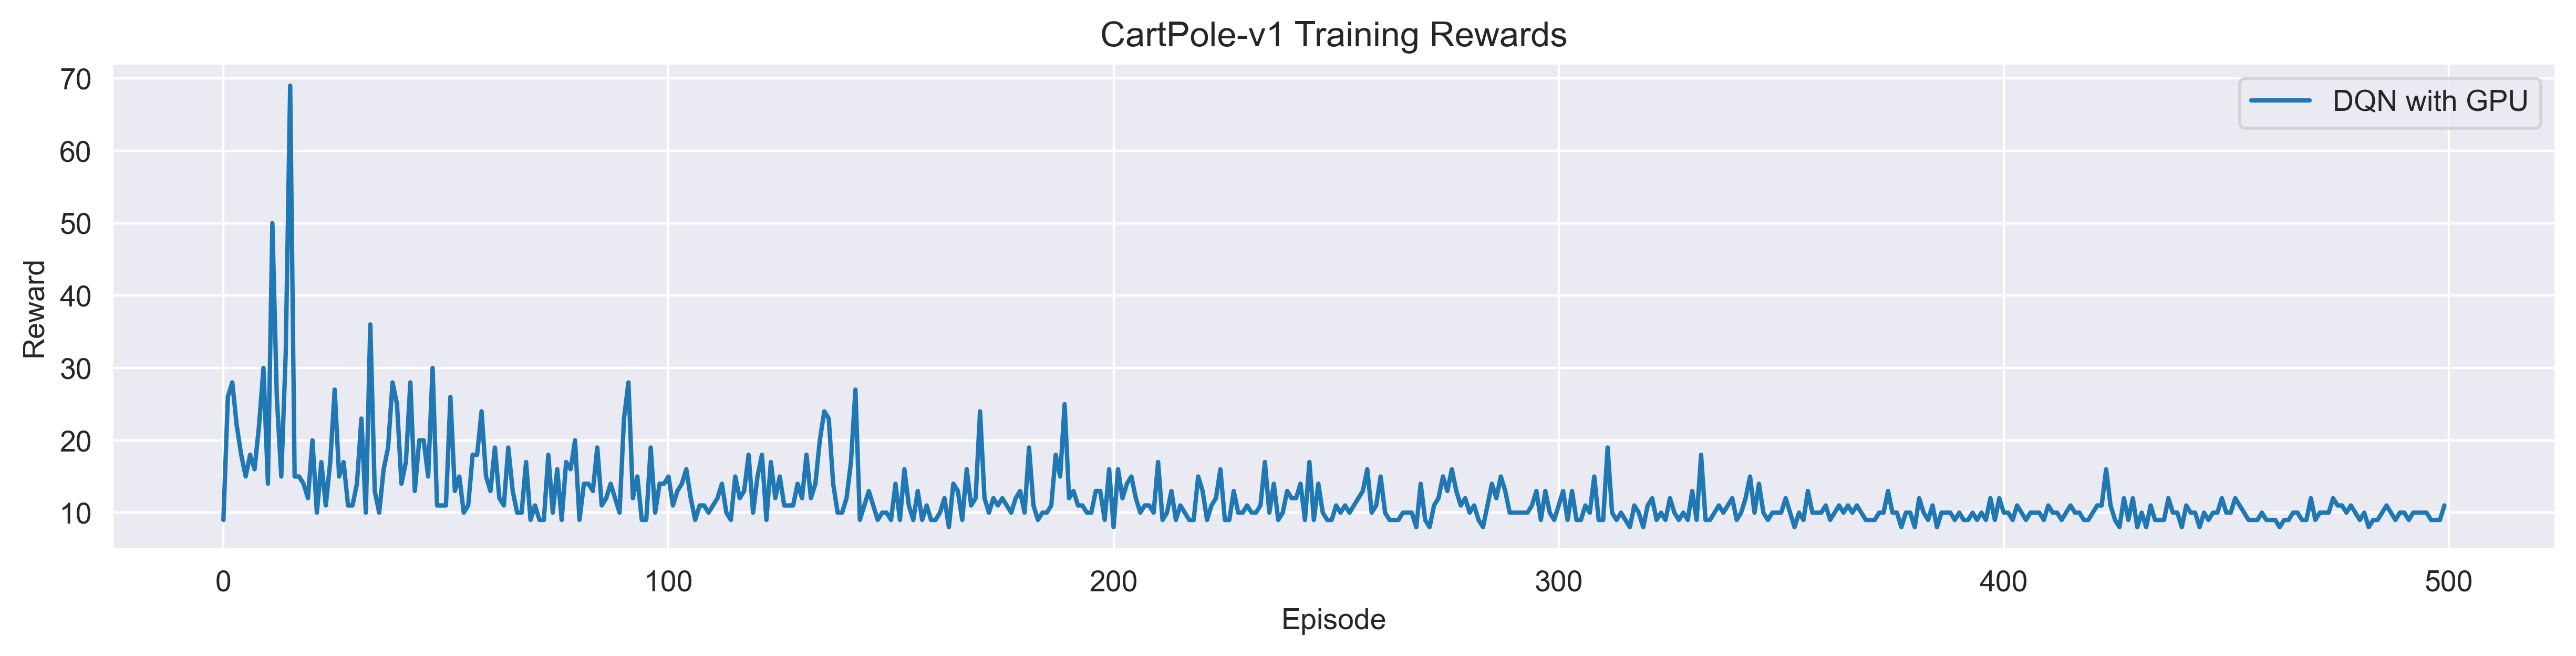

Final epsilon: 0.08157186144027828
First 10 episode rewards: [9.0, 26.0, 28.0, 22.0, 18.0, 15.0, 18.0, 16.0, 22.0, 30.0]
Last 10 episode rewards: [10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 11.0]
Average reward over last 100 episodes: 9.89


In [6]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="DQN with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 Training Rewards")
plt.legend()
plt.show()

print(f"Final epsilon: {agent.epsilon}")
print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")